<a href="https://colab.research.google.com/github/sheshanCharuka/Audio_DataSet_Quality_AI_Project/blob/main/Audio_Dataset_Quality_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Phase 1: Preparation & Setup
Objective: Install tools and create the folder structure (raw, quarantine, clean) as defined in your plan.

Explanation:

We use librosa for analysis and soundfile to save the converted (16kHz mono) files.

We use Python to automatically create the folder structure in your Google Drive so you don't have to do it manually.

In [ ]:
# --- STEP 1: INSTALL LIBRARIES ---
# We install 'sox' (system level) and python libraries
!sudo apt-get install sox
!pip install librosa soundfile pandas numpy tqdm

# --- STEP 2: MOUNT DRIVE ---
from google.colab import drive
drive.mount('/content/drive')

# --- STEP 3: SETUP FOLDER STRUCTURE ---
import os

BASE_PATH = '/content/drive/MyDrive/AI_Audio_Project'

# Define sub-directories based on your plan
DIRS = {
    'raw': os.path.join(BASE_PATH, 'raw_data'),
    'clean': os.path.join(BASE_PATH, 'clean_data'),
    'quarantine': os.path.join(BASE_PATH, 'quarantine')
}

# Create directories if they don't exist
for key, path in DIRS.items():
    os.makedirs(path, exist_ok=True)
    print(f"Directory ready: {path}")

print("\n Setup Complete. Please upload your audio files to the 'raw_data' folder now.")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-base
  libsox3 libwavpack1
Suggested packages:
  libsox-fmt-all
The following NEW packages will be installed:
  libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-base
  libsox3 libwavpack1 sox
0 upgraded, 7 newly installed, 0 to remove and 1 not upgraded.
Need to get 617 kB of archives.
After this operation, 1,764 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libopencore-amrnb0 amd64 0.1.5-1 [94.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libopencore-amrwb0 amd64 0.1.5-1 [49.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libsox3 amd64 14.4.2+git20190427-2+deb11u2ubuntu0.22.04.1 [240 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 l

Phase 2: Automated Screening (The Core Script)

Objective: This is the heavy lifter. It iterates through the raw folder, checks every file against the "Quality Standards" and sorts them.

Methodology & Algorithms:
  1. Format Standardization: We force load every file as 16,000 Hz Mono.
  2. SNR Calculation (Signal-to-Noise Ratio):
    Concept: We estimate the "noise floor" by looking at the quietest 10% of the audio signal.
    Formula:
        SNR(db) = 10 lg (Ps/Pn)
  3. Clipping Detection: Checks if samples hit the maximum value (1.0 or -1.0), indicating distortion.
  4. Sorting Logic:
      PASS: File meets all standards --> Save to clean_data.
      FAIL: File fails any check --> Save to quarantine with a tag in the filename explaining why (e.g., file_LOW_SNR.wav).



SNR         < 15dB    Fail: Too much background noise.

Clipping    > 1.0%    Fail: Audio is distorted/too loud.

Duration    < 1.0s    Fail: File is effectively empty.

Duration    > 10.0s   Fail: File is too long for the model.

In [ ]:
import librosa
import soundfile as sf
import numpy as np
import pandas as pd
import glob
import shutil
from tqdm import tqdm

CONFIG = {
    'target_sr': 16000,        # Standard format: 16kHz
    'min_duration': 1.0,       # Minimum seconds
    'max_duration': 10.0,      # Maximum seconds
    'min_snr_db': 15.0,        # Minimum SNR (15-20dB is usually good for speech)
    'max_clipping_pct': 1.0,   # Max % of samples allowed to be clipped
    'silence_thresh': 0.001    # Threshold to consider a frame "silent"
}

def calculate_snr(y):
    """
    Estimates SNR by assuming the lowest 10% energy frames are noise.
    """
    # Calculate energy of the signal
    energy = y ** 2
    if len(energy) == 0: return 0

    # Sort energy values to find the noise floor (quietest 10%)
    sorted_energy = np.sort(energy)
    noise_len = max(1, int(0.1 * len(energy)))

    noise_power = np.mean(sorted_energy[:noise_len])
    signal_power = np.mean(energy)

    if noise_power == 0: return 100 # Perfect signal (avoid div by zero)

    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def process_and_sort_files():
    raw_files = glob.glob(os.path.join(DIRS['raw'], "*.wav"))
    print(f"Found {len(raw_files)} files to process...")

    report_data = []

    for file_path in tqdm(raw_files):
        filename = os.path.basename(file_path)
        fail_reasons = []

        try:
            # 1. INTEGRITY CHECK & FORMAT CONVERSION
            # Load file, resampling to 16k and forcing mono automatically
            y, sr = librosa.load(file_path, sr=CONFIG['target_sr'], mono=True)
            duration = librosa.get_duration(y=y, sr=sr)

            # 2. DURATION CHECK
            if duration < CONFIG['min_duration']:
                fail_reasons.append("Too_Short")
            elif duration > CONFIG['max_duration']:
                fail_reasons.append("Too_Long")

            # 3. FIDELITY CHECK (Clipping)
            # Check percentage of samples close to max amplitude (1.0)
            clipping_pct = np.sum(np.abs(y) >= 0.99) / len(y) * 100
            if clipping_pct > CONFIG['max_clipping_pct']:
                fail_reasons.append("Clipping")

            # 4. FIDELITY CHECK (SNR)
            snr_val = calculate_snr(y)
            if snr_val < CONFIG['min_snr_db']:
                fail_reasons.append("Low_SNR")

            # 5. SORTING LOGIC
            if not fail_reasons:
                # --- SUCCESS CASE ---
                # Save the standardized version to CLEAN folder
                out_path = os.path.join(DIRS['clean'], filename)
                sf.write(out_path, y, CONFIG['target_sr'])
                status = "Approved"
            else:
                # --- FAILURE CASE ---
                # Save to QUARANTINE folder with error tag
                reason_str = "_".join(fail_reasons)
                new_filename = f"{os.path.splitext(filename)[0]}_{reason_str}.wav"
                out_path = os.path.join(DIRS['quarantine'], new_filename)
                sf.write(out_path, y, CONFIG['target_sr'])
                status = "Quarantined"

            # Log data for the report
            report_data.append({
                "filename": filename,
                "duration": round(duration, 2),
                "snr": round(snr_val, 2),
                "clipping": round(clipping_pct, 2),
                "status": status,
                "reasons": ", ".join(fail_reasons)
            })

        except Exception as e:
            print(f"Error processing {filename}: {e}")
            report_data.append({"filename": filename, "status": "Corrupt/Error", "reasons": str(e)})

    return pd.DataFrame(report_data)

# Run the pipeline
df_report = process_and_sort_files()
print("\nProcessing Complete!")

Found 277 files to process...


100%|██████████| 277/277 [01:22<00:00,  3.34it/s]


Processing Complete!


Phase 3: Validation & Finalization (The Review)

Objective: Review the results. As per your plan, you need to verify the automated flags and generate a final report.

This code generates a summary of how many files passed/failed and allows you to interactively listen to "Quarantined" files directly in Colab without downloading them.


In [ ]:
import IPython.display as ipd

# 1. Generate Summary Statistics
print("--- FINAL QUALITY REPORT ---")
print(f"Total Files: {len(df_report)}")
print(f"Approved:    {len(df_report[df_report['status']=='Approved'])}")
print(f"Quarantined: {len(df_report[df_report['status']=='Quarantined'])}")
print("-" * 30)

# 2. Visualize Failure Reasons
if not df_report.empty:
    fail_counts = df_report[df_report['status']!='Approved']['reasons'].value_counts()
    print("\nTop Rejection Reasons:")
    print(fail_counts)

# 3. Interactive Review Widget
# This will list 5 random quarantined files for you to listen to
quarantined_files = glob.glob(os.path.join(DIRS['quarantine'], "*.wav"))

if quarantined_files:
    print("\n--- HUMAN REVIEW: QUARANTINE SAMPLE ---")
    print("Listening to a sample of rejected files to verify automated flags...")

    # Pick up to 3 random files to review
    import random
    samples = random.sample(quarantined_files, min(len(quarantined_files), 7))

    for f_path in samples:
        fname = os.path.basename(f_path)
        print(f"\nFile: {fname}")
        # Extract reasons from filename (we appended them earlier)
        print(f"Flagged Reason: {fname.split('_')[-1].replace('.wav','')}")
        ipd.display(ipd.Audio(f_path))
else:
    print("\nNo files in quarantine! Great quality dataset.")

--- FINAL QUALITY REPORT ---
Total Files: 277
Approved:    163
Quarantined: 114
------------------------------

Top Rejection Reasons:
reasons
Too_Long     105
Too_Short      6
Low_SNR        3
Name: count, dtype: int64

--- HUMAN REVIEW: QUARANTINE SAMPLE ---
Listening to a sample of rejected files to verify automated flags...

File: cat_43_Too_Long.wav
Flagged Reason: Long



File: cat_95_Too_Long.wav
Flagged Reason: Long



File: cat_45_Too_Long.wav
Flagged Reason: Long



File: cat_133_Low_SNR.wav
Flagged Reason: SNR



File: cat_159_Too_Long.wav
Flagged Reason: Long



File: cat_160_Too_Long.wav
Flagged Reason: Long



File: cat_128_Too_Long.wav
Flagged Reason: Long


/tmp/ipython-input-988724640.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=all_reasons, ax=axes[2], palette='Reds_r')


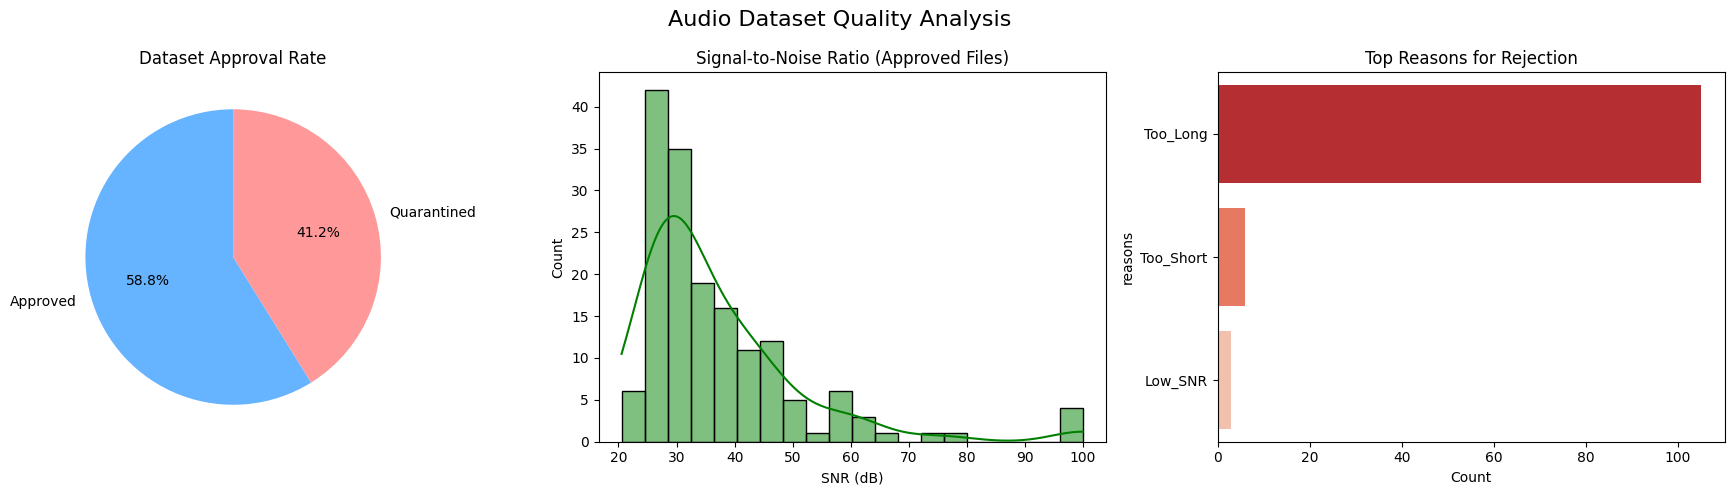

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure we have the data
if 'df_report' in locals() and not df_report.empty:

    # Set up the figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    plt.suptitle('Audio Dataset Quality Analysis', fontsize=16)

    # 1. PIE CHART: Pass vs. Fail
    status_counts = df_report['status'].value_counts()
    axes[0].pie(status_counts, labels=status_counts.index, autopct='%1.1f%%',
                colors=['#66b3ff','#ff9999'], startangle=90)
    axes[0].set_title('Dataset Approval Rate')

    # 2. HISTOGRAM: SNR Distribution (Quality of Good Files)
    # We only look at files that passed the check
    clean_data = df_report[df_report['status'] == 'Approved']
    if not clean_data.empty:
        sns.histplot(clean_data['snr'], bins=20, kde=True, ax=axes[1], color='green')
        axes[1].set_title('Signal-to-Noise Ratio (Approved Files)')
        axes[1].set_xlabel('SNR (dB)')
    else:
        axes[1].text(0.5, 0.5, "No Approved Files", ha='center')

    # 3. BAR CHART: Failure Reasons
    # Filter for failed files and count reasons
    failed_data = df_report[df_report['status'] != 'Approved']
    if not failed_data.empty:
        # Split reasons if a file has multiple (e.g., "Low_SNR, Clipping")
        all_reasons = failed_data['reasons'].str.split(',').explode()
        sns.countplot(y=all_reasons, ax=axes[2], palette='Reds_r')
        axes[2].set_title('Top Reasons for Rejection')
        axes[2].set_xlabel('Count')
    else:
        axes[2].text(0.5, 0.5, "No Rejected Files", ha='center')

    plt.tight_layout()
    plt.show()


else:
    print("❌ No data found. Please run the processing step (Phase 2) first.")

**Dataset Improvement part..**

Phase 1: Environment & Library Setup

Need specialized libraries for cleaning (noisereduce) and augmentation (audiomentations).

In [ ]:
# 1. Install Specialized Libraries
!pip install librosa soundfile pandas numpy matplotlib seaborn tqdm
!pip install noisereduce  # For removing background static
!pip install audiomentations # For professional data augmentation

# 2. Import Libraries
import os
import glob
import librosa
import soundfile as sf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import noisereduce as nr
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
from google.colab import drive

# 3. Mount Drive
drive.mount('/content/drive')

# 4. Setup Folder Structure
BASE_PATH = '/content/drive/MyDrive/AI_Audio_Project' # New Project Folder
DIRS = {
    'raw': os.path.join(BASE_PATH, 'raw_data'),
    'clean': os.path.join(BASE_PATH, 'clean_data'),
    'quarantine': os.path.join(BASE_PATH, 'quarantine'),
    'augmented': os.path.join(BASE_PATH, 'augmented_final')
}

for key, path in DIRS.items():
    os.makedirs(path, exist_ok=True)
    print(f"Created: {path}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Created: /content/drive/MyDrive/AI_Audio_Project/raw_data
Created: /content/drive/MyDrive/AI_Audio_Project/clean_data
Created: /content/drive/MyDrive/AI_Audio_Project/quarantine
Created: /content/drive/MyDrive/AI_Audio_Project/augmented_final


The Cleaning & Augmentation Engine

This is the core logic. We define two separate functions: one to clean the audio and one to generate variations of it.

Cleaning: Uses noisereduce to learn the noise profile and subtract it, then trims silence.

Augmentation: Uses audiomentations to create 3 new variations for every 1 original file (oversampling).

In [ ]:
# --- CONFIGURATION ---
SAMPLE_RATE = 16000
SNR_THRESHOLD = 15.0 # We want files better than this

# --- DEFINE AUGMENTATION PIPELINE ---
# This creates synthetic variations of your data
augmenter = Compose([
    # 1. Change speed slightly (make it faster/slower)
    TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    # 2. Change pitch (make voice deeper/higher)
    PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
    # 3. Add very slight background noise (helps model generalize)
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.3),
])

def clean_audio(y, sr):
    """
    1. Removes stationary noise (static/hum).
    2. Trims leading/trailing silence.
    """
    # Step A: Noise Reduction
    # We assume the noise is constant-ish. prop_decrease=0.75 means reduce noise by 75%
    # (Going to 1.0 might damage the human voice)
    y_clean = nr.reduce_noise(y=y, sr=sr, prop_decrease=0.75, stationary=True)

    # Step B: Trim Silence
    # top_db=20 means anything quieter than -20dB is considered silence
    y_trimmed, _ = librosa.effects.trim(y_clean, top_db=20)

    return y_trimmed

def process_pipeline():
    raw_files = glob.glob(os.path.join(DIRS['raw'], "*"))
    print(f"Found {len(raw_files)} raw files. Starting processing...")

    if len(raw_files) == 0:
        print("❌ STOP: No files found in 'raw_data'. Please upload data.")
        return

    for file_path in tqdm(raw_files):
        try:
            filename = os.path.basename(file_path)
            base_name = os.path.splitext(filename)[0]

            # 1. LOAD
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE, mono=True)

            # 2. CLEAN & SAVE (The 'Improved' Original)
            y_clean = clean_audio(y, sr)
            clean_out_path = os.path.join(DIRS['clean'], f"{base_name}_clean.wav")
            sf.write(clean_out_path, y_clean, sr)

            # 3. AUGMENTATION (Oversampling / Synthetic Generation)
            # We generate 3 new versions for every 1 clean file
            # This effectively triples your dataset size.

            # Save the clean version to the final folder first
            sf.write(os.path.join(DIRS['augmented'], f"{base_name}_original.wav"), y_clean, sr)

            for i in range(3): # Generate 3 variations
                y_aug = augmenter(samples=y_clean, sample_rate=sr)
                aug_name = f"{base_name}_aug_{i}.wav"
                sf.write(os.path.join(DIRS['augmented'], aug_name), y_aug, sr)

        except Exception as e:
            print(f"Error processing {filename}: {e}")

    print("\n Processing Complete!")
    print(f"Cleaned files are in: {DIRS['clean']}")
    print(f"Final Augmented Dataset is in: {DIRS['augmented']}")

# Run the pipeline
process_pipeline()

Found 277 raw files. Starting processing...


100%|██████████| 277/277 [01:46<00:00,  2.59it/s]


✅ Processing Complete!
Cleaned files are in: /content/drive/MyDrive/AI_Audio_Project/clean_data
Final Augmented Dataset is in: /content/drive/MyDrive/AI_Audio_Project/augmented_final


Phase 3: The Comparator (Accuracy Check)

Now we must prove that the project worked. We will calculate the SNR (Signal-to-Noise Ratio) for the Raw Input and compare it to the Final Output.

Hypothesis: The "Final" folder should have higher SNR (cleaner audio) and more files (oversampling).

Analyzing 1. Raw Input dataset (277 files)...


100%|██████████| 277/277 [00:02<00:00, 98.75it/s] 


Analyzing 2. Cleaned & Augmented dataset (1108 files)...


100%|██████████| 1108/1108 [00:15<00:00, 69.47it/s] 
/tmp/ipython-input-1950426045.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Dataset', data=df_compare, ax=axes[0], palette='viridis')
/tmp/ipython-input-1950426045.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Dataset', y='SNR', data=df_compare, ax=axes[1], palette='viridis')


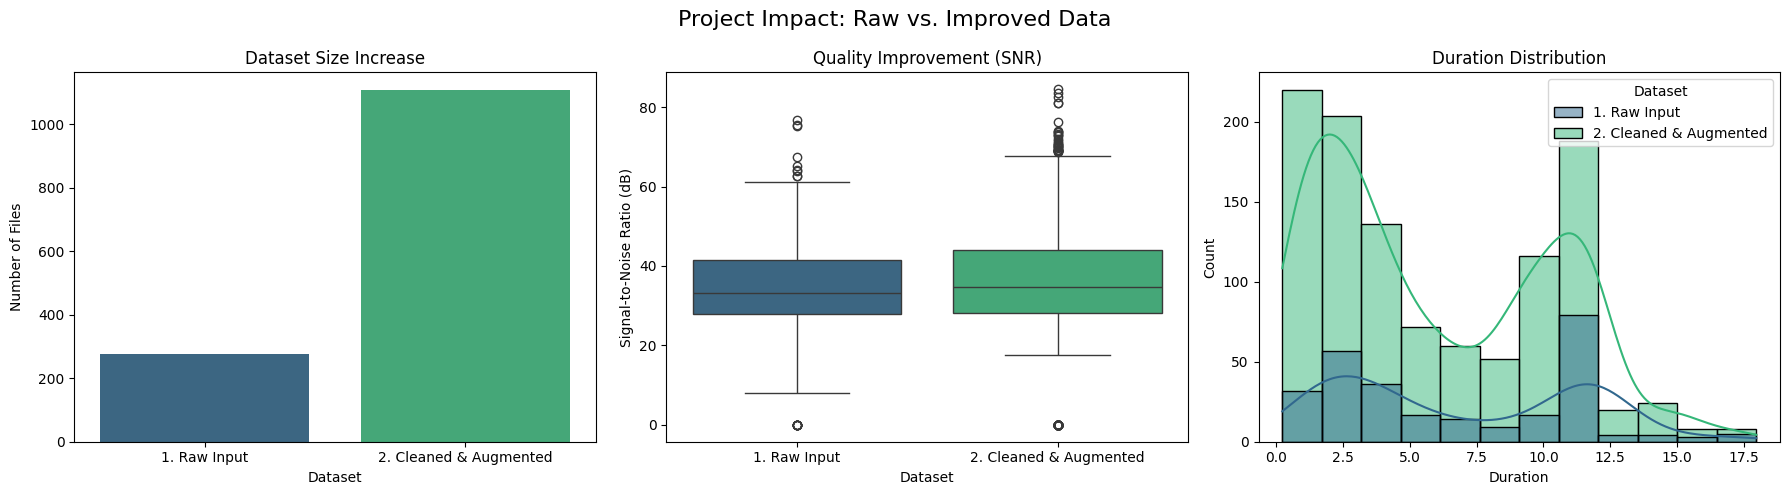


--- FINAL COMPARISON SUMMARY ---
                              SNR  Duration
Dataset                                    
1. Raw Input            35.108505  6.939842
2. Cleaned & Augmented  35.993454  6.001080


In [ ]:
def calculate_metrics(folder_path, label):
    files = glob.glob(os.path.join(folder_path, "*.wav"))
    metrics_list = []

    print(f"Analyzing {label} dataset ({len(files)} files)...")

    for f in tqdm(files):
        try:
            y, sr = librosa.load(f, sr=None) # Load native SR

            # SNR Calculation
            energy = y ** 2
            if len(energy) == 0: continue
            # Assume lowest 10% energy is noise
            noise_power = np.mean(np.sort(energy)[:max(1, int(0.1 * len(energy)))])
            signal_power = np.mean(energy)

            snr = 0
            if noise_power > 0:
                snr = 10 * np.log10(signal_power / noise_power)

            metrics_list.append({
                "Dataset": label,
                "SNR": snr,
                "Duration": librosa.get_duration(y=y, sr=sr)
            })
        except:
            pass

    return pd.DataFrame(metrics_list)

# 1. Analyze Input vs Output
df_raw = calculate_metrics(DIRS['raw'], "1. Raw Input")
df_final = calculate_metrics(DIRS['augmented'], "2. Cleaned & Augmented")

# Combine data
df_compare = pd.concat([df_raw, df_final])

# 2. VISUALIZATION OF IMPROVEMENT
if not df_compare.empty:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    plt.suptitle('Project Impact: Raw vs. Improved Data', fontsize=16)

    # Chart 1: Dataset Size Growth (Oversampling)
    sns.countplot(x='Dataset', data=df_compare, ax=axes[0], palette='viridis')
    axes[0].set_title('Dataset Size Increase')
    axes[0].set_ylabel('Number of Files')

    # Chart 2: Quality Improvement (SNR)
    sns.boxplot(x='Dataset', y='SNR', data=df_compare, ax=axes[1], palette='viridis')
    axes[1].set_title('Quality Improvement (SNR)')
    axes[1].set_ylabel('Signal-to-Noise Ratio (dB)')

    # Chart 3: Duration Consistency
    sns.histplot(data=df_compare, x='Duration', hue='Dataset', kde=True, ax=axes[2], palette='viridis')
    axes[2].set_title('Duration Distribution')

    plt.tight_layout()
    plt.show()

    # 3. PRINT SUMMARY STATISTICS
    print("\n--- FINAL COMPARISON SUMMARY ---")
    print(df_compare.groupby('Dataset')[['SNR', 'Duration']].mean())
else:
    print("No data to compare. Make sure files were processed.")